# Stock Predictions with Regression

### Predict end of week (eow) closing price

- import dependencies
- import dataset
- make regression algorithms
- make predictions

In [1]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [0]:
## Further  recommendation, test multiple frameworks, see what works better on average. 
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

import seaborn as sns
sns.set()

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import TheilSenRegressor

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
## Save future files to your drive
## In this notebook control for multiple testing
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/Colab Notebooks/Stock Prediction with Regression"
! if test -d "input"; then rm -r "input"; fi
%mkdir "input"

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Stock Prediction with Regression


In [4]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
TICKER="SHOP"
INPUT_DATA = "input/%s.csv" % TICKER
df_full = pdr.get_data_yahoo(TICKER, interval="5d", period="max").reset_index()
df_full.to_csv(INPUT_DATA,index=False)

[*********************100%***********************]  1 of 1 downloaded


In [5]:
df_full = pd.read_csv(INPUT_DATA)
df_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-20,17.000000,17.000000,17.000000,17.000000,17.000000,0
1,2015-06-04,27.420000,27.490000,25.510000,26.780001,26.780001,322600
2,2015-06-09,26.639999,28.459999,26.639999,28.340000,28.340000,337500
3,2015-06-19,36.330002,36.740002,32.549999,35.520000,35.520000,979700
4,2015-06-24,35.119999,37.429001,34.139999,35.959999,35.959999,564400


In [6]:
df_full.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
210,2019-08-22,391.880005,392.829987,380.019989,388.540009,388.540009,2084800
211,2019-08-27,402.700012,409.609985,398.500000,406.989990,406.989990,2791900
212,2019-09-06,393.489990,395.750000,380.140015,380.420013,380.420013,1723700
213,2019-09-11,338.399994,350.700012,336.100006,347.510010,347.510010,3215200
214,2019-09-13,356.529999,357.500000,337.640015,338.309998,338.309998,2645598


In [7]:
df_full.columns.values

array(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype=object)

In [8]:
df_full.info()
df_full.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 7 columns):
Date         215 non-null object
Open         215 non-null float64
High         215 non-null float64
Low          215 non-null float64
Close        215 non-null float64
Adj Close    215 non-null float64
Volume       215 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 11.8+ KB


,Open,High,Low,Close,Adj Close,Volume
count,215.000000,215.000000,215.000000,215.000000,215.000000,2.150000e+02
mean,107.319005,109.540967,105.214307,107.559255,107.559255,1.388020e+06
std,87.598298,88.912832,85.747592,87.284743,87.284743,1.364059e+06
min,17.000000,17.000000,17.000000,17.000000,17.000000,0.000000e+00
25%,34.720002,36.615002,33.335001,35.415001,35.415001,6.805500e+05
50%,91.910004,95.720001,91.900002,93.500000,93.500000,1.060800e+06
75%,143.159996,146.557007,140.784996,144.934997,144.934997,1.739300e+06
max,402.700012,409.609985,398.500000,406.989990,406.989990,1.292710e+07


## Notes
- all features do not have missing data (in terms of count)
- 1088 number of data for every features
- no "bad/null/empty" data as `min` of all features has a value (except `Volume` as day 1 is 0)

- removing following features:
 - `Date, High, Low, Adj Close`: not relevant for training

- adding following features:
 - `next_eow_close`: using this as target feature as we want to predict the next end of week closing price based on this week's performance


In [0]:
# Create new feature which will be the target price (next day)
# Remove last row as it doesn't have a next_day_close value
remove_features = ['Date', 'High', 'Low', 'Adj Close']
rename_mapper = {'Open': 'open', 'Close': 'close', 'Volume': 'volume'}
df_full['next_day_close'] = pd.Series(np.append(df_full['Close'][1:].to_numpy(), [0]))
df_full.drop(df_full.tail(1).index, inplace=True)
df_full.drop(remove_features, axis=1, inplace=True)
df_full.rename(columns=rename_mapper, inplace=True)


In [10]:
train, test = train_test_split(df_full, test_size=0.1, shuffle=False)
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 191
Data columns (total 4 columns):
open              192 non-null float64
close             192 non-null float64
volume            192 non-null int64
next_day_close    192 non-null float64
dtypes: float64(3), int64(1)
memory usage: 7.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 192 to 213
Data columns (total 4 columns):
open              22 non-null float64
close             22 non-null float64
volume            22 non-null int64
next_day_close    22 non-null float64
dtypes: float64(3), int64(1)
memory usage: 880.0 bytes


In [11]:
train.head()

,open,close,volume,next_day_close
0,17.000000,17.000000,0,26.780001
1,27.420000,26.780001,322600,28.340000
2,26.639999,28.340000,337500,35.520000
3,36.330002,35.520000,979700,35.959999
4,35.119999,35.959999,564400,31.320000


In [0]:
def plot_prediction(regressor, y_pred, y_actual):
    close_price = y_actual
    pred_price = pd.Series(y_pred, index=close_price.index.values)
    close_price.head(15).plot(label='actual')
    pred_price.head(15).plot(label='prediction')
    title = "%s on %s ticker" % (regressor.strip(), TICKER)
    plt.title(title)
    plt.legend()

In [13]:
# Set up training and testing data
X_train = train.drop("next_day_close", axis=1)
Y_train = train["next_day_close"]
X_test = test.drop("next_day_close", axis=1)
Y_expected = test["next_day_close"]
X_train.shape, Y_train.shape, X_test.shape


((192, 3), (192,), (22, 3))

Linear Regression
 R2:  0.8505710918497229 MSE: 365.8789127297237


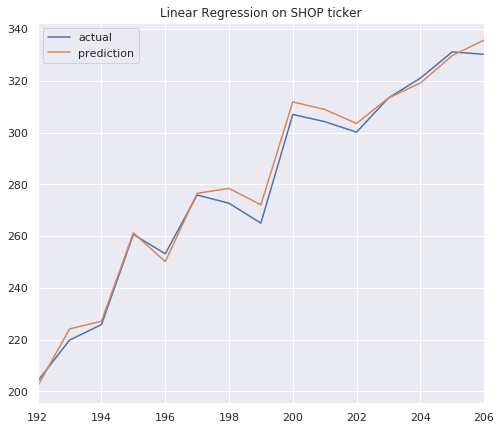

In [14]:
# Linear Regression

linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)
Y_pred = linear_reg.predict(X_test)
linear_r2 = r2_score(Y_expected, Y_pred)
linear_mse = mean_squared_error(Y_expected, Y_pred)
print("Linear Regression\n", "R2: ", linear_r2, "MSE:" ,linear_mse)
plot_prediction("Linear Regression", Y_pred, test['close'])

Lasso Lars Regression
 R2:  -0.7551354330630555 MSE: 4297.475313790765


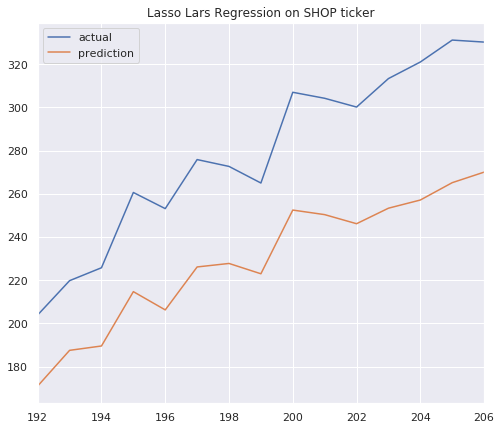

In [15]:
# Lasso Lars

lassolars_reg = LassoLars()
lassolars_reg.fit(X_train, Y_train)
Y_pred = lassolars_reg.predict(X_test)
lassolars_r2 = r2_score(Y_expected, Y_pred)
lassolars_mse = mean_squared_error(Y_expected, Y_pred)
print("Lasso Lars Regression\n", "R2: ", lassolars_r2, "MSE:" ,lassolars_mse)
plot_prediction("Lasso Lars Regression", Y_pred, test['close'])

Theil Sen Regression
 R2:  0.8568370803599713 MSE: 350.53654630487495


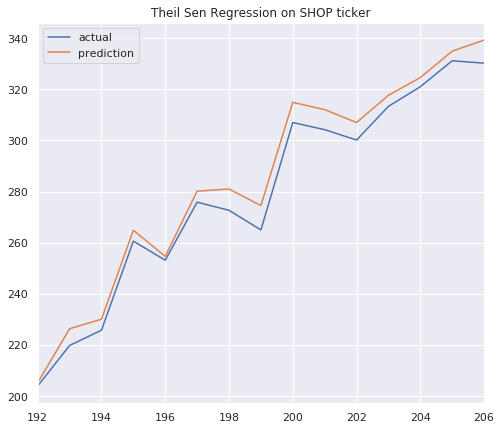

In [16]:
# Theil Sen Regressor

theil_reg = TheilSenRegressor()
theil_reg.fit(X_train, Y_train)
Y_pred = theil_reg.predict(X_test)
theil_r2 = r2_score(Y_expected, Y_pred)
theil_mse = mean_squared_error(Y_expected, Y_pred)
print("Theil Sen Regression\n", "R2: ", theil_r2, "MSE:" ,theil_mse)
plot_prediction("Theil Sen Regression", Y_pred, test['close'])

Bayesian Ridge Regression
 R2:  0.8511098133896066 MSE: 364.5598449956645


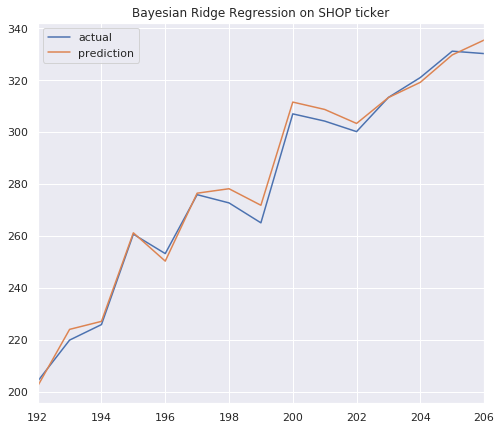

In [17]:
# Bayesian Ridge

bayesian_reg = BayesianRidge()
bayesian_reg.fit(X_train, Y_train)
Y_pred = bayesian_reg.predict(X_test)
bayesian_r2 = r2_score(Y_expected, Y_pred)
bayesian_mse = mean_squared_error(Y_expected, Y_pred)
print("Bayesian Ridge Regression\n", "R2: ", bayesian_r2, "MSE:" ,bayesian_mse)
plot_prediction("Bayesian Ridge Regression", Y_pred, test['close'])